#### Introduction


In this practice, I'm going to use the sentiment analysis based on the tweet data on flight. My analysis will be focus on the tweet text, so other factors I may not consider too much. And I will focus on the negative sentiment, since I personally think that negative comments bears a lot insights we can use directly. 

My primiary idea is like this: \
I'm going to prepare the data, extract features, then use the bag-of-word, TfIdf as well as deep learning models to do analytics. Also, I will do a little bit visualization to make the data information presented directly.

Here's the routine: 
- Load and Get Familiar with Data, Explore the Label Distributions
- Clean Text Data and Visualize the Most Common Words
- Extract Features
- Modeling, Validation and Summary


#### Requiring libraries and Loading Data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import sklearn
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
%matplotlib inline

In [2]:
df0 = pd.read_csv('Tweets.csv')
df0.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### Data Prepare & Exploratory Analysis

There are several columns in this dataset, however, I will only consider the text and label in this practice

In [3]:
df0.shape

(14640, 15)

In [4]:
df0.isna().sum() # a lot missing values, but it doesn't matter, since I only focus on the text and label

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [5]:
# transform the label factors into 0 and 1, so that it will be simplier for further modeling
df1 = df0[['airline_sentiment', 'text']]
df1['sentiment']=np.where(df1['airline_sentiment']=='negative', 1, 0)
#df1.isna().sum()
df1.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,text,sentiment
0,neutral,@VirginAmerica What @dhepburn said.,0
1,positive,@VirginAmerica plus you've added commercials t...,0
2,neutral,@VirginAmerica I didn't today... Must mean I n...,0
3,negative,@VirginAmerica it's really aggressive to blast...,1
4,negative,@VirginAmerica and it's a really big bad thing...,1


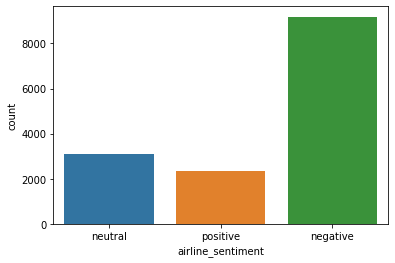

In [6]:
# visualize the label distribution
sns.countplot(x='airline_sentiment', data = df1)

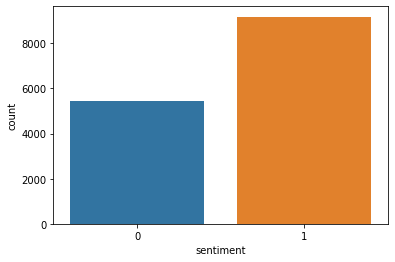

In [7]:
sns.countplot(x='sentiment', data = df1)

In [8]:
# remove the unimportant patterns

# remove '@' pattern
def remove_pattern(txt, pattern):
    r = re.findall(pattern, txt)
    for i in r:
        txt = re.sub(i, '', txt)
    return txt
df1['temp_text'] = np.vectorize(remove_pattern)(df1['text'], '@[\w]*')

# remove url pattern
def remove_URL(txt):
    return re.sub(r'http\S+', '', txt)
df1['temp_text'] = np.vectorize(remove_URL)(df1['temp_text'])


# remove special characters
df1['temp_text'] = df1['temp_text'].str.replace('[^a-zA-Z#]', ' ')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [9]:
# tokenization and remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
df1['temp_text'] = df1['temp_text'].apply(lambda x: ' '.join([y for y in x.split() if y not in stop_words]))
tokenized_txt = df1['temp_text'].apply(lambda x: x.split())
tokenized_txt.head()

[nltk_data] Downloading package stopwords to /Users/na/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


0                                         [What, said]
1        [plus, added, commercials, experience, tacky]
2    [I, today, Must, mean, I, need, take, another,...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: temp_text, dtype: object

In [10]:
# stemming, consider the word root only
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_txt = tokenized_txt.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_txt.head()

for i in range(len(tokenized_txt)):
    tokenized_txt[i] = ' '.join(tokenized_txt[i])
    
df1['tidy_text'] = tokenized_txt
df1.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,airline_sentiment,text,sentiment,temp_text,tidy_text
0,neutral,@VirginAmerica What @dhepburn said.,0,What said,what said
1,positive,@VirginAmerica plus you've added commercials t...,0,plus added commercials experience tacky,plu ad commerci experi tacki
2,neutral,@VirginAmerica I didn't today... Must mean I n...,0,I today Must mean I need take another trip,I today must mean I need take anoth trip
3,negative,@VirginAmerica it's really aggressive to blast...,1,really aggressive blast obnoxious entertainmen...,realli aggress blast obnoxi entertain guest fa...
4,negative,@VirginAmerica and it's a really big bad thing...,1,really big bad thing,realli big bad thing


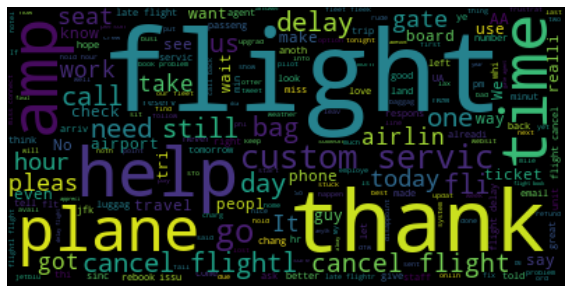

In [11]:
# word cloud visualization
all_words = ' '.join([i for i in df1['tidy_text']])
from wordcloud import WordCloud
wordcloud = WordCloud().generate(all_words)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()


In [12]:
## extract features

# bag-of-word features
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df = 0.9, min_df=2, max_features = 1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df1['tidy_text'])

# TfIDF features
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, min_df=2, max_features = 1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df1['tidy_text'])

#### Modeling & Validation

###### Bag-of-Words & TfIDF Methods

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.linear_model import LogisticRegression

# train & test df 
# 0.8*len(df1)=0.8*14640 = 11712
train = df1[:11712]
test = df1[11712:]

# bag-of-words
# bow.shape # (14640, 3000)
# train & test with bow features
train_bow = bow[:11712, :]
test_bow = bow[11712:, :]


# trian & validation split
Xtrain_bow, Xval_bow, ytrain, yval = train_test_split(train_bow, train['sentiment'], test_size=0.3, random_state=42)


lreg = LogisticRegression()
lreg.fit(Xtrain_bow, ytrain)

pred = lreg.predict_proba(Xval_bow)
pred_int = pred[:,1] >= 0.3
pred_int = pred_int.astype(np.int)


test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1]>0.3
test_pred_int = test_pred_int.astype(np.int)

pd.DataFrame([[accuracy_score(yval, pred_int),f1_score(yval, pred_int),log_loss(yval, pred_int)],
[accuracy_score(test['sentiment'], test_pred_int),f1_score(test['sentiment'], test_pred_int),log_loss(test['sentiment'], test_pred_int)]],
            columns=['accuracy', 'f1 score', 'log_loss'],
            index = ['train', 'test'])


,accuracy,f1 score,log_loss
train,0.786568,0.844720,7.371820
test,0.812158,0.876014,6.487927


In [27]:
# TfIDF
train_tfidf = tfidf[:11712,:]
test_tfidf = tfidf[:11712,:]

Xtrain_tfidf, Xval_tfidf, ytrain, yval = train_test_split(train_tfidf, train['sentiment'], test_size=0.3, random_state=42)

lreg.fit(Xtrain_tfidf, ytrain)

pred = lreg.predict_proba(Xval_tfidf)
pred_int = pred[:,1]>0.3
pred_int = pred_int.astype(np.int)

test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1]>0.3
test_pred_int = test_pred_int.astype(np.int)

pd.DataFrame([[accuracy_score(yval, pred_int),f1_score(yval, pred_int),log_loss(yval, pred_int)],
[accuracy_score(test['sentiment'], test_pred_int),f1_score(test['sentiment'], test_pred_int),log_loss(test['sentiment'], test_pred_int)]],
            columns=['accuracy', 'f1 score', 'log_loss'],
            index = ['train', 'test'])



,accuracy,f1 score,log_loss
train,0.762094,0.835108,8.217143
test,0.818648,0.883065,6.263815


###### Deep Learning Methods

In [17]:
from numpy import array
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations

In [18]:
maxfeatures = 5000
maxlen = 100
out_dim = 100
tokenizer = Tokenizer(num_words = maxfeatures)
tokenizer.fit_on_texts(train['tidy_text'])

X_train = tokenizer.texts_to_sequences(train['tidy_text'])
X_test = tokenizer.texts_to_sequences(test['tidy_text'])

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen = maxlen)

y_train = np.array(train['sentiment'])
y_test = np.array(test['sentiment'])

In [19]:
model = Sequential()
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=out_dim, input_length=maxlen)
model.add(embedding_layer)
model.add(layers.Dropout(0.3))
conv1d = layers.Conv1D(filters=32, kernel_size=3, activation='relu')
model.add(conv1d)
maxpooling1d = layers.MaxPooling1D(pool_size=2)
model.add(maxpooling1d)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          769600    
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 32)            9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                2

In [21]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 5s 582us/sample - loss: 0.6414 - acc: 0.6276 - val_loss: 0.4994 - val_acc: 0.7567
Epoch 2/10
9369/9369 [==============================] - 4s 417us/sample - loss: 0.4339 - acc: 0.8036 - val_loss: 0.3555 - val_acc: 0.8395
Epoch 3/10
9369/9369 [==============================] - 4s 420us/sample - loss: 0.3324 - acc: 0.8615 - val_loss: 0.3395 - val_acc: 0.8481
Epoch 4/10
9369/9369 [==============================] - 4s 431us/sample - loss: 0.2829 - acc: 0.8838 - val_loss: 0.3564 - val_acc: 0.8434
Epoch 5/10
9369/9369 [==============================] - 4s 435us/sample - loss: 0.2436 - acc: 0.9021 - val_loss: 0.3590 - val_acc: 0.8566
Epoch 6/10
9369/9369 [==============================] - 4s 437us/sample - loss: 0.2167 - acc: 0.9170 - val_loss: 0.3828 - val_acc: 0.8459
Epoch 7/10
9369/9369 [==============================] - 4s 425us/sample - loss: 0.1933 - acc: 0.9276 - val_loss: 0.4001 - va

In [22]:
score = model.evaluate(X_test, y_test)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

2928/2928 [==============================] - 0s 102us/sample - loss: 0.5705 - acc: 0.8053
Test Score: 0.5704691753687103
Test Accuracy: 0.8053279


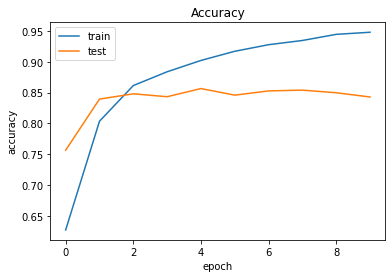

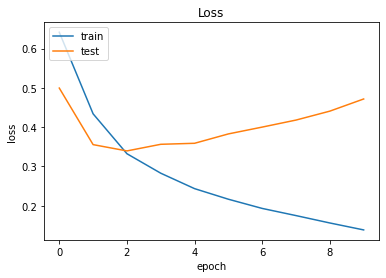

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#### Summary

Overall, the three methods have their pros and cons. Here in this practice, the tfidf method seems to perform slightly better then the other 2, while there still large space to improve for the other 2, even a little change on the parameter may bring some imporvement. To build a good model, there are a lot to explore, either the choosing of models or the parameter setting all matters a lot. 